# Day 10: Multiobjective Optimization

---

Optimization is considerably more complex when we have multiple, competing objectives.

- Examples with multiple objectives
- Dominance, the Pareto frontier
- Scalarization
- Making choices


In [13]:
import pandas as pd 
import grama as gr 
import numpy as np
import plotnine as pt 
DF = gr.Intention()


## Examples with multiple objectives

---


### Buildings

$$\min\, \text{(Weight of building)}$$
$$\min\, \text{(Cost of building)}$$



$$\min\, \text{(Safety of building)}$$
$$\min\, \text{(Cost of building)}$$


### Communications

$$\min\, \text{(Error rate)}$$
$$\min\, \text{(Data rate)}$$


### Materials

$$\min\, \text{Strength}$$
$$\min\, \text{Toughness}$$

![toughness vs strength](./images/toughness_v_strength.jpg)

Via [Wikimedia](https://commons.wikimedia.org/wiki/File:Fracture_toughness_vs._Strength.jpg), CC Universal Public Domain Declaration


## Dominance and the Pareto Frontier

---


Design runtime estimates unavailable; model has no timing data.


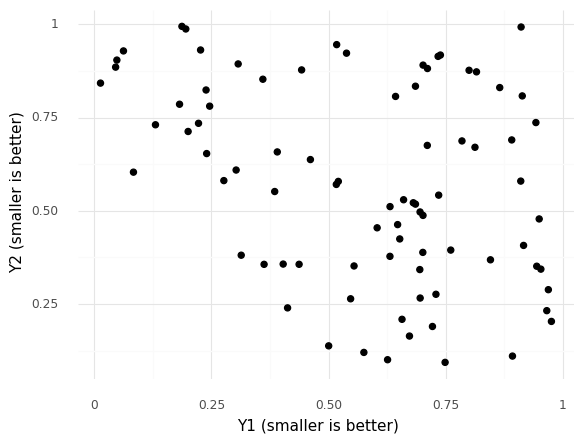

<ggplot: (8784682348541)>

In [10]:
## A fake-data example
df_pop = (
    gr.Model()
    >> gr.cp_marginals(
        y1=dict(dist="uniform", loc=0, scale=1),
        y2=dict(dist="uniform", loc=0, scale=1),
    )
    >> gr.cp_copula_independence()
    >> gr.ev_monte_carlo(n=100, df_det="nom", seed=101, skip=True)
    >> gr.tf_filter((DF.y1 - 1)**2 + (DF.y2 - 1)**2 <= 1)
)

(
    df_pop
    >> pt.ggplot(pt.aes("y1", "y2"))
    + pt.geom_point(size=2)
    
    + pt.theme_minimal()
    + pt.labs(
        x="Y1 (smaller is better)",
        y="Y2 (smaller is better)",
    )
)

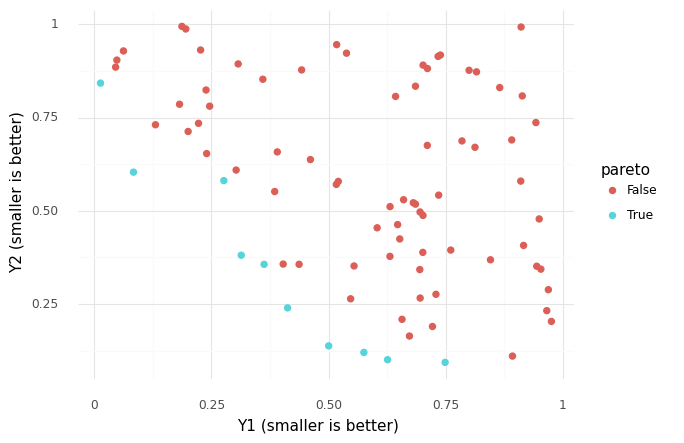

<ggplot: (8784682356321)>

In [11]:
(
    df_pop
    >> gr.tf_mutate(pareto=gr.pareto_min(DF.y1, DF.y2))
    
    >> pt.ggplot(pt.aes("y1", "y2", color="pareto"))
    + pt.geom_point(size=2)
    
    + pt.theme_minimal()
    + pt.labs(
        x="Y1 (smaller is better)",
        y="Y2 (smaller is better)",
    )
)


Single objective

It is clear if $a < b$ or $a > b$ (or equal)


Multiple objectives $Y_1, Y_2$

It is now possible for a candidate to be neither better nor worse than another candidate.

![dominance figure](./images/obj-multi.png)


Definition (Pareto dominance): Let $y, y' \in \mathbb{R}^m$ be points in objective space, i.e. $y = f(x)$. Assume (without loss of generality) that all objectives $y_i$ are to be minimized. The point $y$ *dominates* $y'$ if and only if

$$y_i \leq y'_i\text{ for all }i\in\{1, \dots, m\}$$
$$y_i < y'_i\text{ for some }i$$

In words, a point $y$ dominates $y'$ if:
1. $y$ is no worse than $y'$ in any criteria
2. $y$ is strictly better in at least one criterion


Definition (Pareto frontier): Let $S \subseteq \mathbb{R}^m$ be a set of points in objective space. The *Pareto frontier* $P(S)$ is the set of non-dominated points, that is

$$P(S) = \{y \,|\, y \in S\text{ and } y\text{ non-dominated by }y'\text{ for all }y\neq y'\in S\}$$


With a finite set of points (say, a dataset), you can use the function `gr.pareto_min()` to identify the pareto points. For instance, in the example above, we used the line:

```
(
    df_pop
    >> gr.tf_mutate(pareto=gr.pareto_min(DF.y1, DF.y2))
)
```

to compute the pareto points according to the objectives $y1, y2$.


## Scalarization

---


Weighted Sum Method (Kochenderfer and Wheeler, Ch. 12.3.1)

Idea: Take a weighted sum of the objective values:

$$f(Y) = \sum_{i=1}^m w_i Y_i$$

Rather than minimize the $Y_i$ individually, minimize their weighted sum:

$$\min\, f(Y(x)) = \sum_{i=1}^m w_i Y_i(x)$$

Depending on the choice of weights, we'll land on a different point along the Pareto frontier:


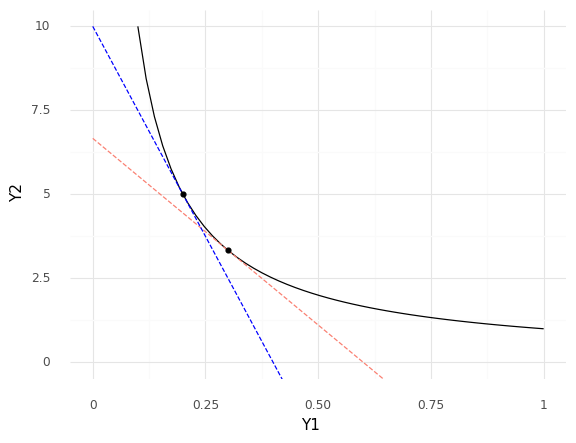

<ggplot: (8784682027680)>

In [27]:
# Test point
xt = 0.3
yt = 1 / xt
mt = -1 / xt**2
# Test point
xp = 0.2
yp = 1 / xp
mp = -1 / xp**2

(
    gr.df_make(x=np.linspace(0.1, 1))
    >> gr.tf_mutate(y=1 / DF.x)
    
    >> pt.ggplot(pt.aes("x", "y"))
    + pt.geom_line()
    # Test point 1
    + pt.geom_line(
        data=gr.df_make(x=np.linspace(0, 1))
        >> gr.tf_mutate(y=yt + mt * (DF.x - xt)),
        linetype="dashed",
        color="salmon",
    )
    + pt.geom_point( data=gr.df_make(x=xt, y=yt) )
    # Test point 2
    + pt.geom_line(
        data=gr.df_make(x=np.linspace(0, 1))
        >> gr.tf_mutate(y=yp + mp * (DF.x - xp)),
        linetype="dashed",
        color="blue",
    )
    + pt.geom_point( data=gr.df_make(x=xp, y=yp) )
    
    + pt.theme_minimal()
    + pt.coord_cartesian(ylim=(0, 10))
    + pt.labs(x="Y1", y="Y2")
)

With the weight method, it is best to try a variety of weights to "sketch out" the Pareto frontier. You'll practice this on the homework. 


## Tips on Making Choices

---
